## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler,StandardScaler,PowerTransformer,QuantileTransformer,MinMaxScaler
from imblearn.over_sampling import SMOTE, SVMSMOTE, SMOTENC, KMeansSMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import ClusterCentroids, AllKNN, NeighbourhoodCleaningRule, TomekLinks, RepeatedEditedNearestNeighbours
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,f1_score

## Loading the train and test data

In [2]:
df_train = pd.read_csv('csv_result-Descriptors_Training.csv', index_col='id', na_values=[-9999]).dropna()
df_test = pd.read_csv('csv_result-Descriptors_Calibration.csv', index_col='id', na_values=[-9999]).dropna()

In [3]:
df_train.head()

,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,Gs(U)_IB_58_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
id,,,,,,,,,,,,,,,,,,,,,
1,5.59,14.91,13.69,6.45,12.11,28.79,32.40,0.06,0.09,0.04,...,0.69,23.12,0.64,0.76,-0.79,0.68,0.54,0.02,0.59,P
2,4.81,16.87,6.58,11.59,17.25,40.40,56.59,0.04,0.06,0.05,...,1.32,2.34,0.52,0.49,-1.27,1.39,-0.11,0.02,0.62,P
3,5.36,13.81,8.25,8.77,14.82,32.42,61.74,0.03,0.06,0.07,...,-0.69,-2.24,0.37,0.47,-0.74,2.03,0.58,0.01,0.56,P
4,6.10,73.66,6.41,11.14,37.36,38.26,55.93,0.04,0.19,0.06,...,1.50,2.44,0.40,0.44,-0.28,0.43,0.77,0.02,0.65,P
5,-2.00,16.41,8.51,7.07,30.95,50.22,39.52,0.05,0.05,0.04,...,1.88,7.72,0.42,0.50,-1.12,0.91,0.71,0.01,0.65,P


In [4]:
def get_info(df):
    print(f'Number of Rows in the data    : {df.shape[0]}')
    print(f'Number of Columns in the data : {df.shape[1]}')
    print(f'Number of P samples : {df["class"].value_counts()["P"]}')
    print(f'Number of N samples : {df["class"].value_counts()["N"]}')
    print(f'Ratio of P:N in data : {df["class"].value_counts()["P"]/df["class"].value_counts()["N"]}')

In [5]:
get_info(df_train)

Number of Rows in the data    : 19920
Number of Columns in the data : 29
Number of P samples : 1125
Number of N samples : 18795
Ratio of P:N in data : 0.05985634477254589


In [6]:
get_info(df_test)

Number of Rows in the data    : 4979
Number of Columns in the data : 29
Number of P samples : 281
Number of N samples : 4698
Ratio of P:N in data : 0.05981268624946786


In [7]:
x_cols = df_train.columns.difference({'class'})

In [8]:
x_cols

Index(['ECI_IB_4_N1', 'ECI_IB_5_N1', 'ECI_NO_PCR_CV', 'ECI_NO_UCR_CV',
       'Gs(U)_IB_12_N1', 'Gs(U)_IB_58_N1', 'Gs(U)_IB_60_N1', 'Gs(U)_IB_68_N1',
       'Gs(U)_NO_ALR_SI71', 'HP_NO_sideL35_CV', 'IP_ES_25_N1', 'IP_NO_PLR_S',
       'IP_NO_sideL35_SI71', 'ISA_NO_NPR_S', 'Pa_NO_BSR_SI71', 'Pb_NO_PCR_V',
       'Pb_NO_sideR35_S', 'Z1_IB_10_N1', 'Z1_IB_5_N1', 'Z1_NO_PRT_CV',
       'Z1_NO_sideL35_M', 'Z1_NO_sideR35_CV', 'Z2_NO_AHR_CV', 'Z3_IB_4_N1',
       'Z3_IB_8_N1', 'Z3_NO_NPR_V', 'Z3_NO_UCR_N1', 'Z3_NO_UCR_S'],
      dtype='object')

## Preprocessing the dataset

In [9]:
def label_class(df_tr, df_te):
    d = {'P':1, 'N':0}
    return df_tr.map(d), df_te.map(d)

In [10]:
df_train.loc[:, 'class'], df_test.loc[:, 'class'] = label_class(df_train.loc[:, 'class'], df_test.loc[:, 'class'])

In [28]:
def performance_model(y_org, y_pred):
    print(f'Precision : {precision_score(y_org, y_pred)}')
    print(f'Recall    : {recall_score(y_org, y_pred)}')
    print(f'F1 Score  : {f1_score(y_org, y_pred)}')
    print(f'Confusion :\n {confusion_matrix(y_org, y_pred)}')

In [67]:
def pr_curve(y_org, y_pred):
    lr_precision, lr_recall, _ = precision_recall_curve(y_org, y_pred)
    # plot the precision-recall curves
    plt.plot(lr_recall, lr_precision, label='precision recall curve')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([-0.01,1.01])
    #plt.yticks(np.arange(0,11,1)/10)
    plt.xlim([-0.01,1.01])
    #plt.xticks(np.arange(0,11,1)/10)
    # show the legend
    plt.legend()
    plt.grid()
    #plt.savefig('q2 precision recall curve',dpi=100)
    plt.show()

## Boosting algorithms

In [11]:
learning_rate=[0.1, 0.01, 0.05]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
criterion=['friedman_mse', 'mse']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]+[None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [12]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'gbc__learning_rate':learning_rate,
    'gbc__n_estimators': n_estimators,
    'gbc__max_features': max_features,
    'gbc__criterion':criterion,
    'gbc__max_depth': max_depth,
    'gbc__min_samples_split': min_samples_split,
    'gbc__min_samples_leaf': min_samples_leaf,
}

## Sklearn pipeline

In [17]:
pca = PCA()
rbs = RobustScaler()
gbc = GradientBoostingClassifier(validation_fraction=0.1, verbose=1)
sme = SMOTEENN(sampling_strategy=0.3)
pipe = Pipeline(steps=[('rbs',rbs), ('pca', pca), ('sme', sme), ('gbc', gbc)])

In [18]:
search = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1')
search.fit(df_train.drop('class', axis=1), df_train.loc[:, 'class'])

      Iter       Train Loss   Remaining Time 
         1           1.0904            1.54m
         2           1.0712            1.60m
         3           1.0526            1.60m
         4           1.0346            1.61m
         5           1.0171            1.67m
         6           1.0002            1.64m
         7           0.9837            1.71m
         8           0.9677            1.67m
         9           0.9522            1.65m
        10           0.9371            1.64m
        20           0.8051            1.62m
        30           0.6994            1.57m
        40           0.6123            1.52m
        50           0.5391            1.48m
        60           0.4767            1.45m
        70           0.4229            1.40m
        80           0.3763            1.35m
        90           0.3355            1.30m
       100           0.2997            1.25m
       200           0.1029           50.10s
       300           0.0370           24.90s
       40

RandomizedSearchCV(estimator=Pipeline(steps=[('rbs', RobustScaler()),
                                             ('pca', PCA()),
                                             ('sme',
                                              SMOTEENN(sampling_strategy=0.3)),
                                             ('gbc',
                                              GradientBoostingClassifier(verbose=1))]),
                   n_jobs=-1,
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'mse'],
                                        'gbc__learning_rate': [0.1, 0.01, 0.05],
                                        'gbc__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, None],
                                        'gbc__max_features': ['auto', 'sqrt',
                                  

In [19]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.095):
{'pca__n_components': 10, 'gbc__n_estimators': 400, 'gbc__min_samples_split': 2, 'gbc__min_samples_leaf': 1, 'gbc__max_features': 'auto', 'gbc__max_depth': 80, 'gbc__learning_rate': 0.01, 'gbc__criterion': 'friedman_mse'}


In [31]:
ypred = search.predict_proba(df_test.drop('class', axis=1))

In [34]:
performance_model(df_test['class'], ypred.argmax(1))

Precision : 0.06430446194225722
Recall    : 0.17437722419928825
F1 Score  : 0.09395973154362416
Confusion :
 [[3985  713]
 [ 232   49]]


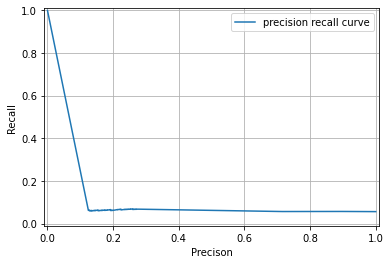

In [43]:
pr_curve(df_test['class'], ypred[:,1])

## Experiment 2 ##system hangs don't run

In [15]:
param_grid = {
    'gbc__learning_rate':learning_rate,
    'gbc__n_estimators': n_estimators,
    'gbc__max_features': max_features,
    'gbc__criterion':criterion,
    'gbc__max_depth': max_depth,
    'gbc__min_samples_split': min_samples_split,
    'gbc__min_samples_leaf': min_samples_leaf,
}

In [16]:
pca = PCA()
rbs = RobustScaler()
gbc = GradientBoostingClassifier(validation_fraction=0.1, verbose=1)
sme = SMOTEENN(sampling_strategy=0.3)
pipe = Pipeline(steps=[('rbs',rbs), ('sme', sme), ('gbc', gbc)])

In [ ]:
search = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1', verbose=1)
search.fit(df_train.drop('class', axis=1), df_train.loc[:, 'class'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [31]:
ypred = search.predict_proba(df_test.drop('class', axis=1))

In [34]:
performance_model(df_test['class'], ypred.argmax(1))

Precision : 0.06430446194225722
Recall    : 0.17437722419928825
F1 Score  : 0.09395973154362416
Confusion :
 [[3985  713]
 [ 232   49]]


## Experiment 3

In [13]:
param_grid = {
    'gbc__learning_rate':learning_rate,
    'gbc__n_estimators': n_estimators,
    'gbc__max_features': max_features,
    'gbc__criterion':criterion,
    'gbc__max_depth': max_depth,
    'gbc__min_samples_split': min_samples_split,
    'gbc__min_samples_leaf': min_samples_leaf,
}

In [14]:
pca = PCA()
rbs = RobustScaler()
gbc = GradientBoostingClassifier(validation_fraction=0.1, verbose=1)
cc = ClusterCentroids(sampling_strategy=0.3)
pipe = Pipeline(steps=[('rbs',rbs), ('cc', cc), ('gbc', gbc)])

In [15]:
search = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1', verbose=1)
search.fit(df_train.drop('class', axis=1), df_train.loc[:, 'class'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\kadap\anaconda3\envs\python3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:172: ConvergenceWarning: Number of distinct clusters (3664) found smaller than n_clusters (3750). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


      Iter       Train Loss   Remaining Time 
         1           1.0669           16.25s
         2           1.0535           15.65s
         3           1.0405           15.69s
         4           1.0276           15.69s
         5           1.0150           15.91s
         6           1.0027           16.19s
         7           0.9906           16.54s
         8           0.9788           16.50s
         9           0.9672           16.45s
        10           0.9560           16.47s
        20           0.8531           15.82s
        30           0.7665           15.26s
        40           0.6927           14.83s
        50           0.6280           14.40s
        60           0.5714           14.01s
        70           0.5210           13.59s
        80           0.4755           13.16s
        90           0.4350           12.76s
       100           0.3985           12.33s
       200           0.1741            8.24s
       300           0.0791            4.12s
       40

RandomizedSearchCV(estimator=Pipeline(steps=[('rbs', RobustScaler()),
                                             ('cc',
                                              ClusterCentroids(sampling_strategy=0.3)),
                                             ('gbc',
                                              GradientBoostingClassifier(verbose=1))]),
                   n_jobs=-1,
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'mse'],
                                        'gbc__learning_rate': [0.1, 0.01, 0.05],
                                        'gbc__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, None],
                                        'gbc__max_features': ['auto', 'sqrt',
                                                              'log2'],
                 

In [16]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.132):
{'gbc__n_estimators': 400, 'gbc__min_samples_split': 5, 'gbc__min_samples_leaf': 4, 'gbc__max_features': 'sqrt', 'gbc__max_depth': 80, 'gbc__learning_rate': 0.01, 'gbc__criterion': 'mse'}


In [17]:
ypred = search.predict_proba(df_test.drop('class', axis=1))

In [19]:
performance_model(df_test['class'], ypred[:1])

Precision : 0.07430997876857749
Recall    : 0.498220640569395
F1 Score  : 0.12933025404157042
Confusion :
 [[2954 1744]
 [ 141  140]]


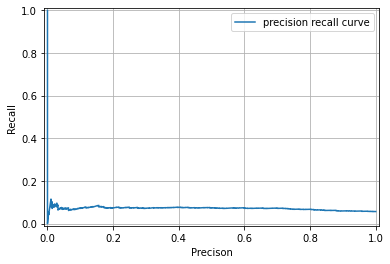

In [22]:
pr_curve(df_test['class'], ypred[:,1])

### Experiment 4

In [14]:
param_grid = {
    'gbc__learning_rate':learning_rate,
    'gbc__n_estimators': n_estimators,
    'gbc__max_features': max_features,
    'gbc__criterion':criterion,
    'gbc__max_depth': max_depth,
    'gbc__min_samples_split': min_samples_split,
    'gbc__min_samples_leaf': min_samples_leaf,
}

In [15]:
pt = PowerTransformer()
gbc = GradientBoostingClassifier(validation_fraction=0.1, verbose=1)
ss = SVMSMOTE(sampling_strategy=0.3)
pipe = Pipeline(steps=[('pt',pt), ('ss', ss), ('gbc', gbc)])

In [16]:
search = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1', verbose=1)
search.fit(df_train.drop('class', axis=1), df_train.loc[:, 'class'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
      Iter       Train Loss   Remaining Time 
         1           0.9478           11.60m
         2           0.9302           11.03m
         3           0.9132           10.39m
         4           0.8969           10.67m
         5           0.8813           10.78m
         6           0.8662           10.75m
         7           0.8516           10.85m
         8           0.8374           10.81m
         9           0.8238           10.95m
        10           0.8106           11.01m
        20           0.6967           12.32m
        30           0.6070           12.81m
        40           0.5335           13.14m
        50           0.4717           13.43m
        60           0.4191           13.55m
        70           0.3737           13.64m
        80           0.3341           13.60m
        90           0.2993           13.63m
       100           0.2688           13.75m
       200           0.0970           

RandomizedSearchCV(estimator=Pipeline(steps=[('pt', PowerTransformer()),
                                             ('ss',
                                              SVMSMOTE(sampling_strategy=0.3)),
                                             ('gbc',
                                              GradientBoostingClassifier(verbose=1))]),
                   n_jobs=-1,
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'mse'],
                                        'gbc__learning_rate': [0.1, 0.01, 0.05],
                                        'gbc__max_depth': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, None],
                                        'gbc__max_features': ['auto', 'sqrt',
                                                              'log2'],
                      

In [17]:
print(f"Best parameter (CV score={search.cv_results_}):" )
print(search.best_params_)

Best parameter (CV score={'mean_fit_time': array([1220.04931464, 2871.30550995,  880.05856171, 4421.46850591,
       1423.02019715,  678.09222574,  502.61419668, 1316.79909534,
        546.86767473,  284.97295547]), 'std_fit_time': array([ 16.96303688, 109.39404322,  27.39565903, 174.29573676,
        37.79316507,  15.17662101,  13.16151073,  49.04236474,
        28.37489252,  30.63802055]), 'mean_score_time': array([2.71075301, 2.74685631, 2.51068764, 5.96266818, 1.59254231,
       0.47453136, 1.43296895, 2.09947276, 1.2253221 , 0.55592895]), 'std_score_time': array([0.26192174, 0.10918962, 0.12543427, 0.97645487, 0.12170308,
       0.02517853, 0.12993747, 0.24120273, 0.15217565, 0.11115226]), 'param_gbc__n_estimators': masked_array(data=[1800, 2000, 2000, 2000, 1000, 1400, 1200, 1600, 1200,
                   600],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_gbc__

In [20]:
ypred = search.predict_proba(df_test.drop('class', axis=1))

In [41]:
performance_model(df_test['class'].to_numpy(),  ypred.argmax(1))

Precision : 0.1724137931034483
Recall    : 0.017793594306049824
F1 Score  : 0.03225806451612903
Confusion :
 [[4674   24]
 [ 276    5]]


In [61]:
lr_precision, lr_recall, thre = precision_recall_curve(df_test['class'].to_numpy(), ypred[:,1])

In [53]:
print(lr_precision[lr_recall>=.5])

[0.05704425 0.05685279 0.05686434 ... 0.08623853 0.08629131 0.08634415]


In [60]:
lr_precision[(lr_recall>=.5) & (lr_recall<.51) & (lr_precision>=0.08)]

array([0.0840188 , 0.0840682 , 0.08411765, 0.08416716, 0.08421673,
       0.08426635, 0.08431604, 0.08436578, 0.08441558, 0.08446545,
       0.08451537, 0.08456535, 0.08461538, 0.08466548, 0.08471564,
       0.08476586, 0.08481613, 0.08486647, 0.08491686, 0.08496732,
       0.08442331, 0.08447353, 0.08452381, 0.08457415, 0.08462455,
       0.08467501, 0.08472554, 0.08477612, 0.08482676, 0.08487747,
       0.08492823, 0.08497905, 0.08502994, 0.08508089, 0.08513189,
       0.08518296, 0.08463385, 0.08468468, 0.08473558, 0.08478653,
       0.08483755, 0.08488862, 0.08493976, 0.08499096, 0.08504222,
       0.08509354, 0.08514493, 0.08519637, 0.08524788, 0.08529946,
       0.08535109, 0.08540279, 0.08545455, 0.08550637, 0.08555825,
       0.0856102 , 0.08566221, 0.08571429, 0.08576642, 0.08581862,
       0.08587089, 0.08592322, 0.08597561, 0.08602807, 0.08608059,
       0.08613317, 0.08618582, 0.08623853, 0.08629131, 0.08634415])

In [50]:
lr_recall[lr_precision>=.08]

array([0.58007117, 0.58007117, 0.58007117, ..., 0.00355872, 0.00355872,
       0.        ])

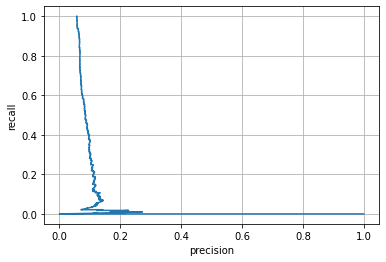

In [66]:
plt.plot(lr_precision, lr_recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid(True)
plt.show()

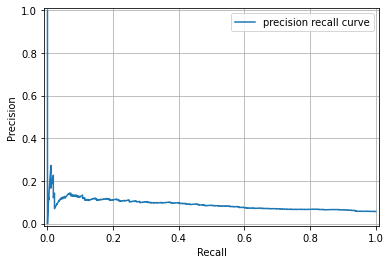

In [68]:
pr_curve(df_test['class'], ypred[:,1])